<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/TrOCR/Inference_with_TrOCR_%2B_Gradio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

We install 🤗 Transformers, which includes many awesome models, including TrOCR by Microsoft Research.

In [1]:
!pip install -q transformers


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load image

Here we load an image from the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database), on which TrOCR was fine-tuned.

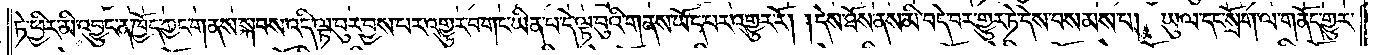

In [1]:
import requests
from PIL import Image

url = "tibetan_dataset/train/1-1-9a_line_9874_3.jpg"
image = Image.open(url).convert("RGB")
image

In [2]:
encode, decode = "google/vit-base-patch16-224-in21k", "sangjeedondrub/tibetan-roberta-base"

## Prepare image for model

Next, we use `TrOCRProcessor` (which wraps a `ViTFeatureExtractor` and a `RobertaTokenizer` into one) to resize + normalize the image for the model.

In [3]:
from transformers import TrOCRProcessor, ViTFeatureExtractor, RobertaTokenizer

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)

processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


torch.Size([1, 3, 224, 224])


C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\models\trocr\processing_trocr.py:45: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


## Load model

Here we load a TrOCR model from the [hub](https://huggingface.co/models?other=trocr). TrOCR models are instances of [`VisionEncoderDecoderModel`](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder), which combine a vision encoder (like ViT, BEiT, DeiT, ...) with a language model as decoder (like BERT, RoBERTa, GPT-2, ...). 

In [4]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("./abc/")

## Generate text 

Finally, we can generate text autoregressively using the `.generate()` method. We use the tokenizer part of the `processor` to decode the generated id's back to text. Note that by default, greedy search is used for generation, but there are more fancy methods like beam search and top-k sampling, which are also supported. You can check out [this blog post](https://huggingface.co/blog/how-to-generate) for details.

In [5]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

གྱི་ཞབས་གཉིས་ལ་མགོ་བོས་ཕྱག་བྱས་ཏེ་ཕྱོགས་གཅིག་ཏུ་འདུག་གོ། །རྒྱལ་པོ་ནོར་ལྡན་གྱིས་


## Gradio demo

We can also wrap up everything we wrote above in a quick [Gradio](https://gradio.app/) demo. Gradio is an awesome tool for creating quick ML demos!

We just need to define a function that takes in an image input and produces a text output (note that Gradio supports many other input & output formats)!

In [15]:
!pip install -q gradio


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import gradio as gr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
from PIL import Image

feature_extractor=ViTFeatureExtractor.from_pretrained(encode)
tokenizer = RobertaTokenizer.from_pretrained(decode)
print(tokenizer.vocab_size)
processor = TrOCRProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)
model = VisionEncoderDecoderModel.from_pretrained("./abc/")

# load image examples from the IAM database
urls = [
    'tibetan_dataset\\train\\1-1-99a_line_9874_3.jpg',
    'tibetan_dataset\\train\\1-1-99a_line_9874_4.jpg',
    'tibetan_dataset\\train\\1-1-99a_line_9874_5.jpg',
    'tibetan_dataset\\train\\1-1-99a_line_9874_6.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_0.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_1.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_2.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_3.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_4.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_5.jpg',
    'tibetan_dataset\\train\\1-1-9a_line_9874_6.jpg'
]
for idx, url in enumerate(urls):
  image = Image.open(url)
  image.save(f"image_{idx}.png")

def process_image(image):
    # prepare image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # generate (no beam search)
    generated_ids = model.generate(pixel_values)

    # decode
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)
    return generated_text

title = "Interactive demo: TrOCR"
description = "Demo for Microsoft's TrOCR, an encoder-decoder model consisting of an image Transformer encoder and a text Transformer decoder for state-of-the-art optical character recognition (OCR) on single-text line images. This particular model is fine-tuned on IAM, a dataset of annotated handwritten images. To use it, simply upload an image or use the example image below and click 'submit'. Results will show up in a few seconds."
article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2109.10282'>TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models</a> | <a href='https://github.com/microsoft/unilm/tree/master/trocr'>Github Repo</a></p>"
examples =[["image_0.png"], ["image_1.png"], ["image_2.png"]]

iface = gr.Interface(fn=process_image, 
                     inputs=gr.inputs.Image(type="pil"), 
                     outputs=gr.outputs.Textbox(),
                     title=title,
                     description=description,
                     article=article,
                     examples=examples)
iface.launch(debug=True)

C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
C:\Users\301212298\source\repos\unilm\venv\lib\site-packages\transformers\models\trocr\processing_trocr.py:45: FutureWarning: The `feature_extractor` argument is deprecated and will be removed in v5, use `image_processor` instead.
  warnings.warn(


22869


C:\Users\301212298\AppData\Local\Temp\ipykernel_10864\4040654582.py:48: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Image(type="pil"),
C:\Users\301212298\AppData\Local\Temp\ipykernel_10864\4040654582.py:48: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Image(type="pil"),
C:\Users\301212298\AppData\Local\Temp\ipykernel_10864\4040654582.py:49: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Textbox(),


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


རྒྱས་རིན་ཆེན་གཙུག་ཏོར་ཅན་གྱི་ཞབས་གཉིས་ལ་མགོ་བོས་ཕྱག་བྱས་ཏེ་ཕྱོགས་གཅིག་གི་ལག་ནས་
